In [1]:
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from utils import (
    gradient_penalty,
    plot_to_tensorboard,
    save_checkpoint,
    load_checkpoint,
    generate_examples,
)
from model import Discriminator, Generator
from math import log2
from tqdm import tqdm
import config

import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils # 这两个是做可视化用的

In [2]:
# 该方法可以自动优化网络结构
torch.backends.cudnn.benchmarks = True

### 加载数据

In [3]:
# 因为是从小到大一点一点训练，所以不同的大小，需要不一样的get_loader
def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(config.CHANNELS_IMG)],
                [0.5 for _ in range(config.CHANNELS_IMG)],
            ),
        ]
    )
    
    # 举个例子，如果image_size 是 4*4的 那么 BATCH_SIZES[0]
    batch_size = config.BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=config.DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset

### 这里对加载的数据集进行一个测试

In [4]:
# 如果image size设置的是 1024， 则batch size为 4
test_loader1, test_dataset1 = get_loader(8)
test_loader2, test_dataset2= get_loader(256)

In [5]:
real_batch1 = next(iter(test_loader1))
real_batch2 = next(iter(test_loader2))
print(real_batch1[0].shape)

torch.Size([16, 3, 8, 8])


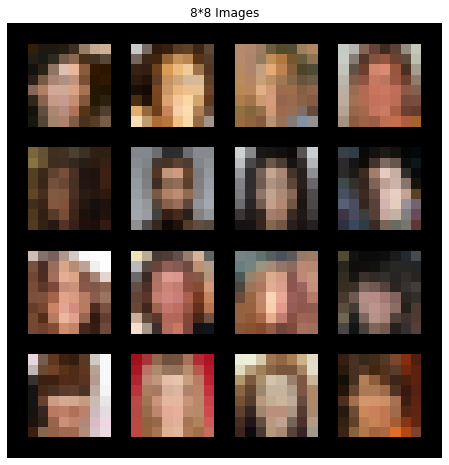

In [6]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("8*8 Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch1[0].to(config.DEVICE)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

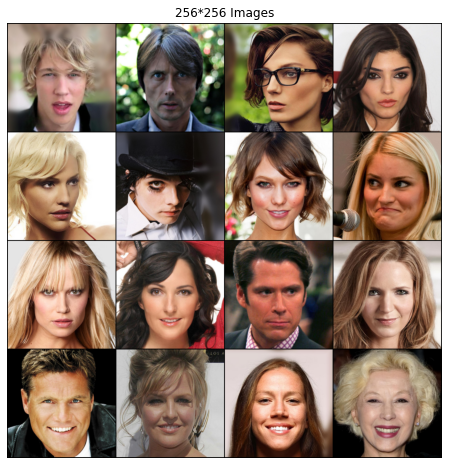

In [7]:
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("256*256 Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch2[0].to(config.DEVICE)[:16], nrow=4, padding=2, normalize=True).cpu(),(1,2,0)))

### 下面是训练方法

In [8]:
def train_fn(critic,gen,loader,dataset,step,alpha,opt_critic,opt_gen,tensorboard_step,writer,scaler_gen,scaler_critic,):
    loop = tqdm(loader,leave=True)
    
    for batch_idx, (real,_) in enumerate(loop):
        
        # 真实的照片
        real = real.to(config.DEVICE)
        cur_batch_size = real.shape[0]
        
        # 训练判别器 max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)] 这个地方用得是WGAN的 LOSS
        noise = torch.randn(cur_batch_size, config.Z_DIM, 1, 1).to(config.DEVICE)
        
        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            
            # 暂时不清楚这一步是在干嘛的 可能和WGAN 有关
            gp = gradient_penalty(critic, real, fake, alpha, step, device=config.DEVICE)
            loss_critic = (-(torch.mean(critic_real) - torch.mean(critic_fake))+ config.LAMBDA_GP * gp + (0.001 * torch.mean(critic_real ** 2)))
        
        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()
        
        # 生成器训练: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)
            
        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()
        
        
        # Update alpha and ensure less than 1
        alpha += cur_batch_size / ((config.PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset))
        alpha = min(alpha, 1)
        
        
        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(config.FIXED_NOISE, alpha, step) * 0.5 + 0.5
                plot_to_tensorboard(writer,loss_critic.item(),loss_gen.item(),real.detach(),fixed_fakes.detach(),tensorboard_step,)
            tensorboard_step += 1

        loop.set_postfix(gp=gp.item(),loss_critic=loss_critic.item())

    return tensorboard_step, alpha
        

### 模型初始化

In [9]:
# 生成器
gen = Generator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# 判别器
critic = Discriminator(config.Z_DIM, config.IN_CHANNELS, img_channels=config.CHANNELS_IMG).to(config.DEVICE)

# 优化器 
# Adam的超参数跟论文中一致
opt_gen = optim.Adam(gen.parameters(),lr=config.LEARNING_RATE,betas=(0.0,0.99))
opt_critic = optim.Adam(critic.parameters(),lr=config.LEARNING_RATE, betas=(0.0,0.99))

# 前向传播精度自适应实例
scaler_gen = torch.cuda.amp.GradScaler()
scaler_critic = torch.cuda.amp.GradScaler()

In [10]:
# for tensorboard plotting
writer = SummaryWriter(f"logs/gan")

In [11]:
# 接下来 是否加载已有模型
if config.LOAD_MODEL:
        load_checkpoint(config.CHECKPOINT_GEN, gen, opt_gen, config.LEARNING_RATE,)
        load_checkpoint(config.CHECKPOINT_CRITIC, critic, opt_critic, config.LEARNING_RATE,)

In [12]:
# 模型中并没有BN层或dropout层 但是还是加了下面的代码，并不清楚源码中该写法的具体用意是什么
gen.train();
# critic.trian() # 会报错，我想这应该没有很大的影响

In [13]:
tensorboard_step = 0

# 一开始是从4*4 开始的
step = int(log2(config.START_TRAIN_AT_IMG_SIZE / 4))
# print(step)

### 模型开始训练

In [14]:
# 该写法意思就是每一个30个epoch训练完 进入下一个30个epoch训练
for num_epochs in config.PROGRESSIVE_EPOCHS[step:]:
    
    # 并不清楚这个值为什么要设置成这样，可能接下来会跟 i 挂钩
    alpha = 1e-5
    loader,dataset = get_loader(4*(2**step))
    
    # 对每一个的训练
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        tensorboard_step, alpha = train_fn(
            critic,
            gen,
            loader,
            dataset,
            step,
            alpha,
            opt_critic,
            opt_gen,
            tensorboard_step,
            writer,
            scaler_gen,
            scaler_critic,
        )
        
        if config.SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=config.CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=config.CHECKPOINT_CRITIC)
            
        
    step += 1 

Epoch [1/30]


100%|████████████████████████████████████████████████| 1875/1875 [01:47<00:00, 17.44it/s, gp=0.0105, loss_critic=0.109]


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████████████████████████████████████████| 1875/1875 [01:47<00:00, 17.51it/s, gp=0.00499, loss_critic=0.0965]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.54it/s, gp=0.00556, loss_critic=0.0357]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|███████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.55it/s, gp=0.00742, loss_critic=0.256]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████████████████████████████████████████| 1875/1875 [01:47<00:00, 17.39it/s, gp=0.00361, loss_critic=0.0733]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|███████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.12it/s, gp=0.00402, loss_critic=0.102]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|███████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.53it/s, gp=0.0053, loss_critic=0.0857]


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████████████████████████████████████████| 1875/1875 [01:43<00:00, 18.08it/s, gp=0.00655, loss_critic=0.0341]


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████████████████████████████████████████| 1875/1875 [01:45<00:00, 17.85it/s, gp=0.00403, loss_critic=-.0745]


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████████████████████████████████████████| 1875/1875 [01:46<00:00, 17.63it/s, gp=0.00479, loss_critic=-.0175]


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|█████████████████████████████████████████████| 1875/1875 [01:45<00:00, 17.80it/s, gp=0.00795, loss_critic=0.00886]


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


 40%|███████████████████▋                             | 755/1875 [00:44<01:05, 17.11it/s, gp=0.0111, loss_critic=0.116]


KeyboardInterrupt: 